In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from subprocess import check_output

In [3]:
df = pd.read_csv('../DL_data/nue_and_numu_pixels.csv', index_col=0)
df.head()

,level_0,index,isTrueTrack,pdg,completeness,purity,x,z,x_scaled,z_scaled,...,775,776,777,778,779,780,781,782,783,nHits
0,0,0,1,2212,1.000000,0.909091,"[119.384, 119.3, 119.172, 119.087, 119.007, 11...","[846.25, 846.55, 846.85, 847.15, 847.45, 847.7...",[ 27. 26. 25. 25. 24. 23. 23. 22. 21. ...,[ 0. 1. 1. 2. 3. 3. 4. 5. 5. ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,41
1,2,2,0,11,0.892892,0.998911,"[165.12, 165.08, 165.017, 164.967, 164.921, 16...","[640.75, 641.05, 641.35, 641.65, 641.95, 642.2...",[ 27. 27. 27. 27. 27. 27. 27. 26. 26. ...,[ 0. 0. 0. 0. 0. 0. 1. 1. 1. ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,247
2,3,3,1,2212,0.989362,0.965398,"[165.52, 165.513, 165.514, 165.499, 165.503, 1...","[638.35, 638.65, 638.95, 639.25, 639.55, 639.8...",[ 0. 0. 0. 0. 0. 0. 0. 0. 1. ...,[ 0. 0. 0. 1. 1. 1. 1. 1. 1. ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136
3,4,4,1,2212,0.875000,0.875000,"[164.341, 164.365, 164.386, 164.427, 164.472, ...","[632.05, 632.35, 632.65, 632.95, 633.25, 633.5...",[ 0. 1. 1. 2. 3. 4. 5. 7. 9. ...,[ 0. 1. 3. 4. 5. 7. 8. 9. 11. ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21
4,7,7,0,11,0.975904,0.852632,"[70.8057, 70.2276, 70.032, 36.6363, 35.3826, 3...","[85.15, 89.65, 90.55, 96.25, 96.25, 96.25, 96....",[ 27. 27. 27. 6. 5. 8. 8. 9. 9. ...,[ 0. 8. 9. 19. 19. 19. 19. 19. 19. ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,73


In [5]:
pixel_cols=[str(i) for i in range(28*28)]

In [8]:
df=df[['isTrueTrack']+pixel_cols]
df.head()

,isTrueTrack,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,1,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0
1,0,255.0,0.0,255.0,0.0,0.0,0.0,255.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df[pixel_cols], df['isTrueTrack'], test_size=0.2, random_state=42)
X_train=(X_train.values).astype('float32')
X_test=(X_test.values).astype('float32')
y_train=(y_train.values).astype('float32')
y_test=(y_test.values).astype('float32')

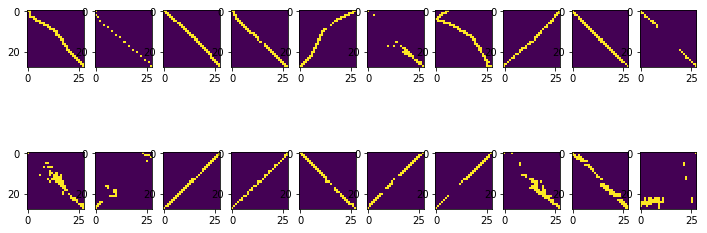

In [30]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(20):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((28,28)),interpolation='nearest')
plt.show()


In [31]:
X_train = X_train/255.0
X_test = X_test/255.0

In [33]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [35]:
batch_size = 64
num_classes = 2
epochs = 20
input_shape = (28, 28, 1)


In [ ]:
# convert class vectors to binary class matrices One Hot Encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [ ]:
#Linear model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
datagen.fit(X_train)
h = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)

In [ ]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
model.save('my_model_1.h5')
json_string = model.to_json()